# Imports

In [1]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

# Set plotting options
params = {'text.usetex' : True,
          'font.size' : 16,
          'font.family' : 'lmodern'
          }
plt.rcParams.update(params) 

# Network class

In [2]:
def relu(x):
    """Rectified linear unit
    
    Input:
    x - numpy array of shape (m, n) where n is the number
        of points and m is the dimension
    
    Return:
    numpy array of shape (m ,n) of the pointwise ReLU
    """
    return np.maximum(x, 0)


def grad_relu(x):
    """Heaviside function
    
    Input:
    x - numpy array of shape (m, n) where n is the number
        of points and m is the dimension
    
    Return:
    numpy array of shape (m ,n) of the pointwise Heaviside
    """
    return (x > 0).astype(float)


class TwoLayerNetwork:
    
    def __init__(self, m0, m1, m2):
        """Initialize the network with random weights.
        
        Input:
        m0 - int for the input dimension
        m1 - int for the hidden layer dimension
        m2 - int for the output dimension
        """
        self.m0 = m0
        self.m1 = m1
        self.m2 = m2
        # Weight matrices
        self.W1 = np.random.randn(m1, m0)
        self.W2 = np.random.randn(m2, m1)
        # Save b1, b2 as column vectors for correct
        # broadcasting during prediction.
        self.b1 = np.random.randn(m1, 1)
        self.b2 = np.random.randn(m2, 1)
   

    def predict(self, X):
        """Evaluate the network on test points.
        
        Input:
        X - numpy array of shape (m0, n) where m0 is the input
            dimension and n is the number of points
        
        Return:
        y2 - numpy array of shape (m2, n) where m2 is the 
             output dimension of the network
        """
        y1 = self.W1 @ X + self.b1
        y2 = self.W2 @ relu(y1) + self.b2
        return y2
     
        
    def grad_loss(self, X, y):
        """Compute the gradient of the loss on the training set.
        
        The loss is given by
        1/n sum_{i=1}^n ||f(x_i) - y_i||^2
        
        Input:
        X - numpy array of shape (m0, n)
        y - numpy array of shape (m2, n)
        
        Return:
        loss - float for the mean-squared error of the network on 
               the training points
        grad_W1 - numpy array of shape (m0, m1)
        grad_W2 - numpy array of shape (m1, m2)
        grad_b1 - numpy array of shape (m1, 1)
        grad_b2 - numpy array of shape (m2, 1)
        """
        n = X.shape[1]  # Number of training samples
        fx = self.predict(X)  # shape (m2, n)
        
        # Pre-compute matrices
        R = fx - y # residuals
        V = self.W2.T @ R
        S = relu(self.W1 @ X + self.b1) # shape (m1, n)
        D = grad_relu(self.W1 @ X + self.b1) # shape (m1, n)
        
        # Multiply the loss by m2 since there are n*m2 elements
        # in the matrices fx, y
        loss = self.m2 * np.mean(R*R)
        
        # Gradients
        grad_W1 = (2/n) * (V * D) @ X.T
        
        grad_W2 = (2/n) * (R @ S.T)
        
        grad_b1 = 2 * np.mean(V * D, axis=1)
        grad_b1 = grad_b1.reshape((self.m1, 1))
        
        grad_b2 = 2 * np.mean(R, axis=1)
        grad_b2 = grad_b2.reshape((self.m2, 1))
        
        return loss, grad_W1, grad_W2, grad_b1, grad_b2
       
        
    def train(self, X, y, lr, epochs):
        """Train the network using gradient descent.
        Updates the network parameters in place.
        
        Input:
        X - numpy array of shape (m0, n)
        y - numpy array of shape (m2, n)
        lr - float > 0 that specifies the learning rate
        epochs - int > 0 that specifies the number of iterations
        
        Return:
        loss - float for the final mean-squared error of the network 
               on the training points
        """   
        for t in tqdm(range(epochs)):  
            # Compute loss function and gradients
            loss, grad_W1, grad_W2, grad_b1, grad_b2 = \
            self.grad_loss(X, y)  
            
            # Update parameters
            self.W1 -= lr*grad_W1
            self.W2 -= lr*grad_W2
            self.b1 -= lr*grad_b1
            self.b2 -= lr*grad_b2        
        return loss

# Test example 1

Approximate the function $f(x) = x^2$.

In [16]:
# Approximating the function x^2
nn = TwoLayerNetwork(1, 15, 1)

# Generate training, validation, and test data
ntrain = 1000
Xtrain = 5*np.random.randn(1, ntrain)
ytrain = Xtrain * Xtrain

nval = 1000
Xval = 5*np.random.randn(1, ntrain)
yval = Xval * Xval

ntest = 1000
Xtest = np.linspace(-10, 10, ntest).reshape((1, ntest))
ytest = Xtest * Xtest

In [17]:
# Train the network and compute validation and training loss
epochs = 2500
lr = 1e-3

train_loss = []
val_loss = []

# Gradient descent update
for t in tqdm(range(epochs)):  
    # Compute loss function and gradients
    loss_t, grad_W1, grad_W2, grad_b1, grad_b2 = \
    nn.grad_loss(Xtrain, ytrain)  
    train_loss.append(loss_t)
    
    # Compute validation loss
    loss_t, _, _, _, _ = nn.grad_loss(Xval, yval)
    val_loss.append(loss_t)
    
    # Update parameters
    nn.W1 -= lr*grad_W1
    nn.W2 -= lr*grad_W2
    nn.b1 -= lr*grad_b1
    nn.b2 -= lr*grad_b2    
    
# Get the prediction on the test data
ypred = nn.predict(Xtest)

100%|██████████| 2500/2500 [00:06<00:00, 387.49it/s]


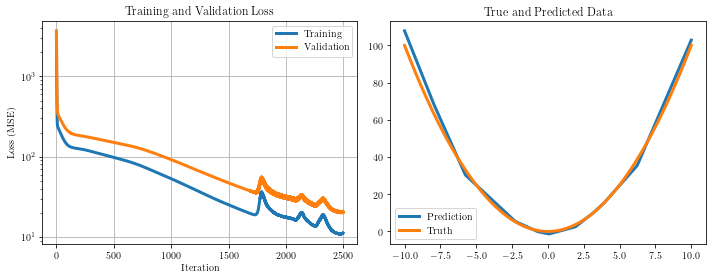

In [19]:
# Plot results
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss (MSE)')
ax[0].semilogy(np.arange(len(train_loss)), train_loss, label='Training', lw=3)
ax[0].semilogy(np.arange(len(val_loss)), val_loss, label='Validation', lw=3)
ax[0].legend()
ax[0].grid()

ax[1].set_title('True and Predicted Data')
ax[1].plot(Xtest.flatten(), ypred.flatten(), label='Prediction', lw=3)
ax[1].plot(Xtest.flatten(), ytest.flatten(), label='Truth', lw=3)
ax[1].legend()

plt.tight_layout()
plt.savefig('test_example_loss.png')

# Test example 2

Approximating the product and max functions.

In [6]:
# f(x) = [x1*x2*x3, max(x1, x2, x3)] nonlinear function
m0 = 3
m1 = 20
m2 = 2

nn = TwoLayerNetwork(m0, m1, m2)

In [7]:
# Training data
n = 10000
X = 10*(np.random.rand(3, n) - 0.5)  # Uniform [-5, 5]
y = np.vstack([X.prod(axis=0), X.max(axis=0)])

In [8]:
nn.train(X, y, 1e-3, 200000)  # Note that this may take 20-30 minutes.

100%|██████████| 200000/200000 [21:25<00:00, 155.59it/s] 


12.815207909936653

In [9]:
# Evaluate the network on a test point
test_point = np.array([1, 2, 3]).reshape((-1, 1))
prediction = nn.predict(test_point)

prod_pred = prediction[0][0]
max_pred = prediction[1][0]

print(prediction)

[[5.93894474]
 [3.63720082]]


# Plot ReLU and gradient

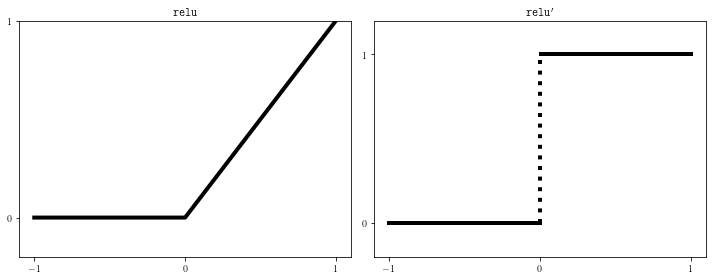

In [10]:
# Plot ReLU and gradient

x = np.linspace(-1, 1, 101)
y = relu(x)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(x,y, lw=4, c='k')
ax[0].set_xticks([-1, 0, 1])
ax[0].set_yticks([0, 1], ["0", "1"])
ax[0].set_ylim([-0.2, 1])
ax[0].set_title('$\\texttt{relu}$')



xn = np.linspace(-1, 0, 101)
yn = grad_relu(xn)

xp = np.linspace(0, 1, 101)[1:]
yp = grad_relu(xp)

ax[1].plot(xn,yn, lw=4, c='k')
ax[1].plot(xp,yp, lw=4, c='k')
ax[1].plot([0,0], [0,1], lw=4, c='k', ls=':')
ax[1].set_xticks([-1, 0, 1])
ax[1].set_yticks([0, 1], ["0", "1"])
ax[1].set_ylim([-0.2, 1.2])
ax[1].set_title('$\\texttt{relu}^{\prime}$')

plt.tight_layout()
#plt.savefig('relu.png')